In [1]:
import numpy as np
import tifffile
from skimage import filters, morphology, measure
import matplotlib.pyplot as plt

In [32]:
tiff_path = "/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/ISH_tiff/HCR-VM11-24-DDRGK1-ctx-10x-1.tif"
image_data = tifffile.imread(tiff_path)
image_data
if len(image_data.shape) == 3:  # (channels, height, width)
    num_channels = image_data.shape[0]
elif len(image_data.shape) == 4:  # (z, channels, height, width) 或 (t, channels, height, width)
    num_channels = image_data.shape[1]
    image_data = image_data[0] if image_data.shape[0] > 1 else image_data
else:
    raise ValueError(f"不支持的图像维度: {image_data.shape}")
if num_channels < 4:
    raise ValueError(f"需要至少4个通道，当前只有{num_channels}个")



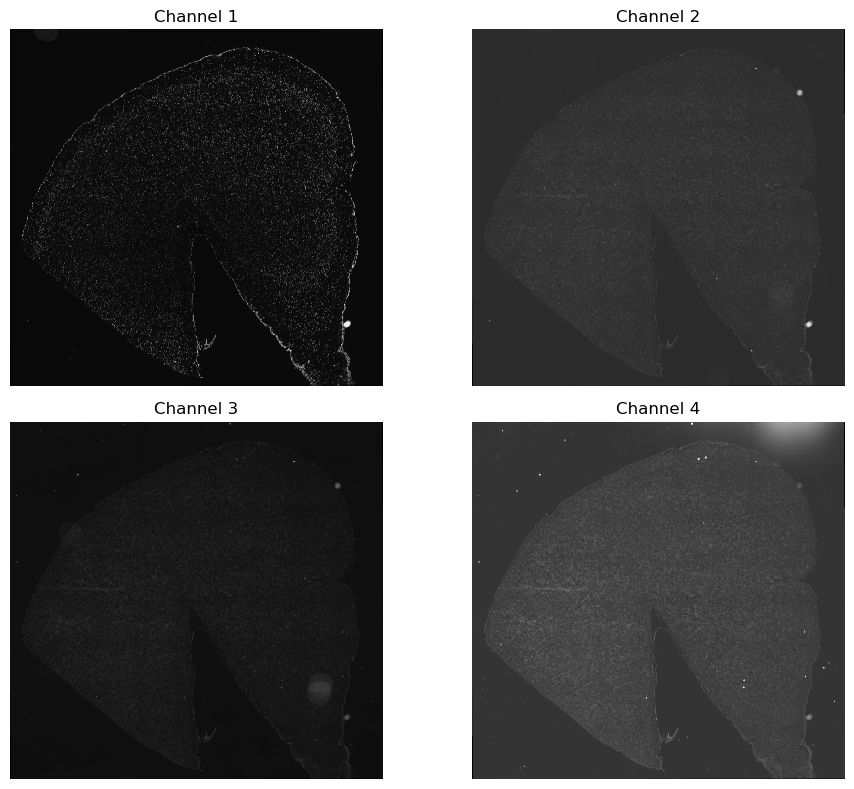

In [33]:
import tifffile
import matplotlib.pyplot as plt

# 确定图像维度
if len(image_data.shape) == 3:  # (channels, height, width)
    num_channels = image_data.shape[0]
    height, width = image_data.shape[1], image_data.shape[2]
    
    # 创建子图显示所有通道
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    
    for i in range(min(num_channels, 4)):
        axes[i].imshow(image_data[i], cmap='gray')
        axes[i].set_title(f'Channel {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

elif len(image_data.shape) == 4:  # 有Z轴或时间轴
    # 取第一个Z层或时间点
    first_slice = image_data[0] if image_data.shape[0] > 1 else image_data
    num_channels = first_slice.shape[0]
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    
    for i in range(min(num_channels, 4)):
        axes[i].imshow(first_slice[i], cmap='gray')
        axes[i].set_title(f'Channel {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [43]:
import numpy as np
from skimage import filters, morphology

def selective_remove_by_intensity_ratio(channel1, channel2, 
                                       ratio_threshold=0.5, 
                                       min_intensity_ch2=None):
    """
    基于强度比值选择性删除重叠区域
    
    参数:
        ratio_threshold: ch1/ch2强度比值阈值，低于此值则保留
        min_intensity_ch2: channel2的最小强度阈值
    """
    # 预处理
    def preprocess(channel):
        channel_norm = (channel - channel.min()) / (channel.max() - channel.min() + 1e-8)
        return filters.gaussian(channel_norm, sigma=1)
    
    ch1_proc = preprocess(channel1)
    ch2_proc = preprocess(channel2)
    
    # 获取掩膜
    thresh1 = filters.threshold_otsu(ch1_proc)
    thresh2 = filters.threshold_otsu(ch2_proc)
    
    mask_ch1 = ch1_proc > thresh1
    mask_ch2 = ch2_proc > thresh2
    
    # 清理掩膜
    mask_ch1 = morphology.remove_small_objects(mask_ch1, min_size=20)
    mask_ch2 = morphology.remove_small_objects(mask_ch2, min_size=20)
    
    # 找到重叠区域
    overlap_mask = np.logical_and(mask_ch1, mask_ch2)
    
    if not np.any(overlap_mask):
        return channel2.copy(), overlap_mask
    
    # 计算重叠区域内每个像素的强度比值
    # 使用原始强度（非归一化）计算
    ch1_overlap = channel1[overlap_mask].astype(np.float32)
    ch2_overlap = channel2[overlap_mask].astype(np.float32)
    
    # 避免除零
    ch2_overlap_safe = np.maximum(ch2_overlap, 1e-8)
    intensity_ratio = ch1_overlap / ch2_overlap_safe
    
    # 创建要删除的掩膜：ch1强度相对ch2太强
    # ratio_threshold=0.5 表示：当ch1强度 > ch2强度的50%时删除
    to_remove_in_overlap = intensity_ratio > ratio_threshold
    
    # 可选：同时要求ch2达到最小强度
    if min_intensity_ch2 is not None:
        ch2_strong_enough = ch2_overlap > min_intensity_ch2
        to_remove_in_overlap = np.logical_and(to_remove_in_overlap, ch2_strong_enough)
    
    # 创建完整的删除掩膜
    remove_mask = np.zeros_like(overlap_mask, dtype=bool)
    overlap_indices = np.where(overlap_mask)
    remove_mask[overlap_indices] = to_remove_in_overlap
    
    # 应用处理
    processed = channel2.copy()
    if np.any(remove_mask):
        # 估算背景值（使用非信号区域）
        non_signal = np.logical_not(mask_ch2)
        if np.any(non_signal):
            background = np.median(channel2[non_signal])
        else:
            background = np.min(channel2)
        
        processed[remove_mask] = background
    
    return processed, remove_mask 

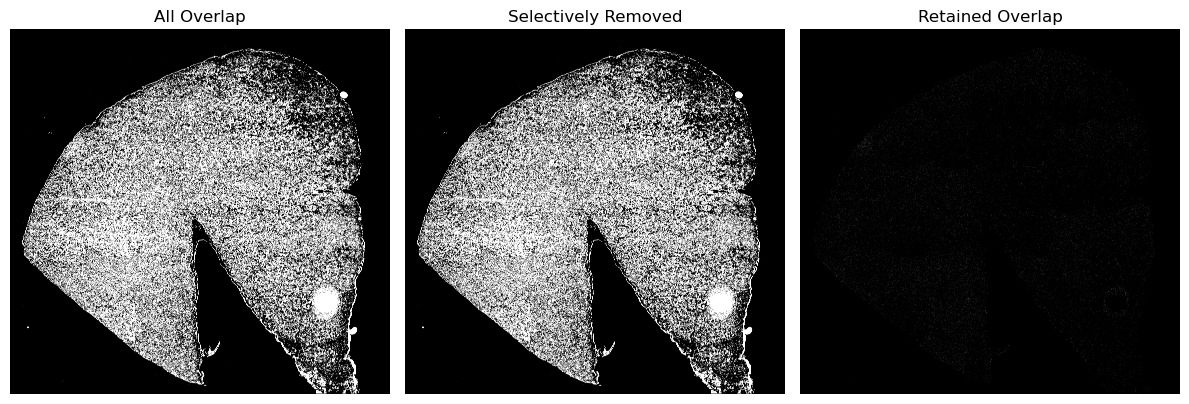

In [52]:
# 在您的代码中替换处理部分
channel1 = image_data[1]
channel2 = image_data[2]
processed_channel2, remove_mask = selective_remove_by_intensity_ratio(
    channel1=channel1,
    channel2=channel2,ratio_threshold=0.2,  # 调整此参数：值越小越保守
    min_intensity_ch2=np.percentile(channel2, 10)
)

# 可视化删除区域
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(overlap_mask, cmap='gray')
axes[0].set_title('All Overlap')
axes[0].axis('off')

axes[1].imshow(remove_mask, cmap='gray')
axes[1].set_title('Selectively Removed')
axes[1].axis('off')

# 显示保留的区域
retained_overlap = np.logical_and(overlap_mask, np.logical_not(remove_mask))
axes[2].imshow(retained_overlap, cmap='gray')
axes[2].set_title('Retained Overlap')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [53]:
processed_stack = image_data.copy()
processed_stack[2] = processed_channel2

# with tifffile.TiffWriter(output_path, bigtiff=True) as tif_writer:
#     tif_writer.save(
#         processed_stack,
#         photometric='minisblack',
#         metadata={'axes': 'CYX'}
#     )
tifffile.imwrite(
        output_path,
        processed_stack,
        imagej=True,           # 关键：启用ImageJ兼容模式
        metadata={'axes': 'CYX', 'channels': 4},
        dtype=image_data.dtype
    )

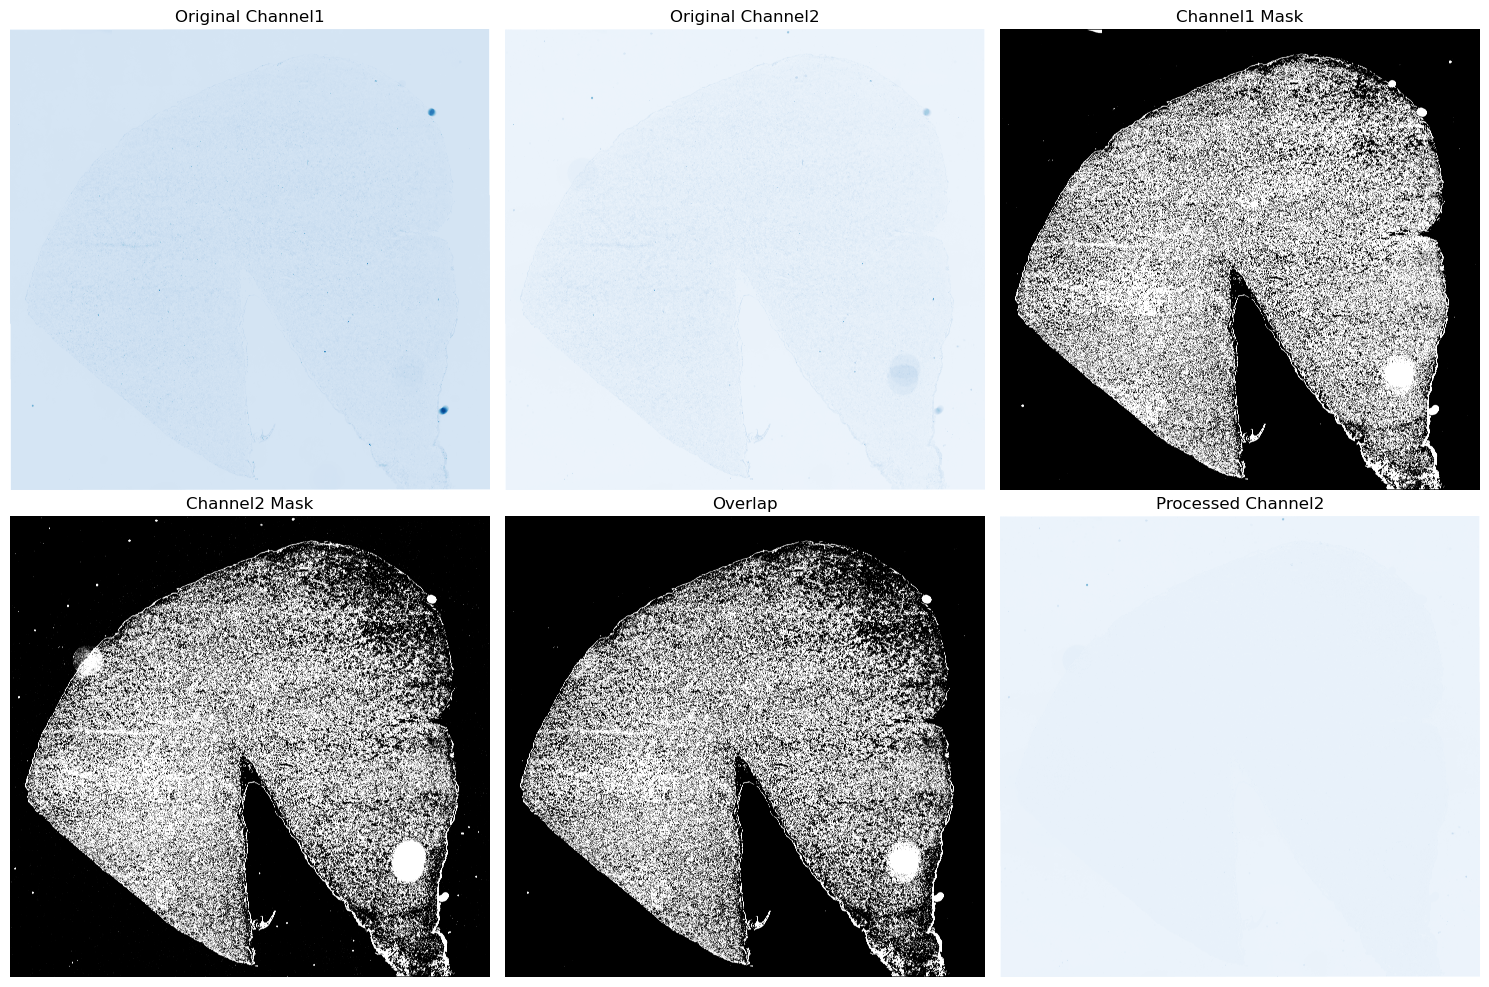

In [39]:
channel1 = image_data[1]
channel2 = image_data[2]
def preprocess_channel(channel):
        # 标准化到0-1范围
        channel_norm = (channel - channel.min()) / (channel.max() - channel.min() + 1e-8)
        # 高斯滤波去噪
        channel_filtered = filters.gaussian(channel_norm, sigma=1)
        return channel_filtered
    
channel1_proc = preprocess_channel(channel1)
channel2_proc = preprocess_channel(channel2)

threshold_ch1 = filters.threshold_otsu(channel1_proc)
mask_ch1 = channel1_proc > threshold_ch1
mask_ch1 = morphology.remove_small_objects(mask_ch1, min_size=20)
mask_ch1 = morphology.binary_closing(mask_ch1, morphology.disk(2))

threshold_ch2 = filters.threshold_otsu(channel2_proc)
mask_ch2 = channel2_proc > threshold_ch2
    
    # 找到重叠区域
overlap_mask = np.logical_and(mask_ch1, mask_ch2)
    
    # 从通道2掩膜中移除重叠区域
mask_ch2_cleaned = np.logical_and(mask_ch2, np.logical_not(overlap_mask))
    
    # 5. 应用清理后的掩膜到原始通道2
    # 创建背景估计（使用非信号区域的中值）
background_value = np.median(channel2[~mask_ch2_cleaned]) if np.any(~mask_ch2_cleaned) else 0
    
    # 生成处理后的图像
processed_channel2 = channel2.copy()
processed_channel2[overlap_mask] = background_value
    
    # 可选：进一步平滑处理
    # processed_channel2 = filters.gaussian(processed_channel2, sigma=0.5)
    
    # 6. 可视化结果（可选）
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
axes[0, 0].imshow(channel1, cmap='Blues')
axes[0, 0].set_title('Original Channel1')
axes[0, 0].axis('off')
    
axes[0, 1].imshow(channel2, cmap='Blues')
axes[0, 1].set_title('Original Channel2')
axes[0, 1].axis('off')
    
axes[0, 2].imshow(mask_ch1, cmap='gray')
axes[0, 2].set_title('Channel1 Mask')
axes[0, 2].axis('off')
    
axes[1, 0].imshow(mask_ch2, cmap='gray')
axes[1, 0].set_title('Channel2 Mask')
axes[1, 0].axis('off')
    
axes[1, 1].imshow(overlap_mask, cmap='gray')
axes[1, 1].set_title('Overlap')
axes[1, 1].axis('off')
    
axes[1, 2].imshow(processed_channel2, cmap='Blues')
axes[1, 2].set_title('Processed Channel2')
axes[1, 2].axis('off')
    
plt.tight_layout()
plt.show()
output_path = "/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/ISH_tiff/HCR-VM11-24-DDRGK1-ctx-10x-1_rm_back.tif"
processed_stack = image_data.copy()
processed_stack[2] = processed_channel2

with tifffile.TiffWriter(output_path, bigtiff=True) as tif_writer:
    tif_writer.save(
        processed_stack,
        photometric='minisblack',
        metadata={'axes': 'CYX'}
    )

In [38]:
tiff_path = "/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/ISH_tiff/HCR-VM11-24-DDRGK1-ctx-10x-1.tif"
def save_imagej_compatible(original_path, processed_channel2, output_path):
    # 读取原始数据
    with tifffile.TiffFile(original_path) as tif:
        original_data = tif.asarray()
    
    # 处理数据
    processed_stack = original_data.copy()
    if len(processed_stack.shape) == 3:
        processed_stack[2] = processed_channel2
    
    # 保存为ImageJ兼容格式
    tifffile.imwrite(
        output_path,
        processed_stack,
        imagej=True,           # 关键：启用ImageJ兼容模式
        metadata={'axes': 'CYX', 'channels': 4},
        dtype=original_data.dtype
    )
    print(f"ImageJ-compatible file saved to: {output_path}")
save_imagej_compatible(tiff_path, processed_channel2, output_path)

ImageJ-compatible file saved to: /cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/ISH_tiff/HCR-VM11-24-DDRGK1-ctx-10x-1_rm_back.tif


开始处理原位杂交图像...
读取文件: /cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/ISH_tiff/HCR-VM11-24-DDRGK1-ctx-10x-1.tif
原始图像信息:
  形状: (4, 16521, 17216)
  数据类型: uint16
  位深度: 16 bpp
  采样格式: 1
  Photometric: 1
  平面配置: 1
  压缩: 1
  通道数: 4
  尺寸: 17216x16521

保存处理后的文件: /cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/ISH_tiff/HCR-VM11-24-DDRGK1-ctx-10x-1_rm_back.tif
输出图像信息:
  形状: (4, 16521, 17216)
  数据类型: uint16
  位深度: 16 bpp
  尺寸: 16521x4

处理统计:
  通道1信号区域面积: 114315416 像素
  通道2原始信号区域面积: 101780423 像素
  重叠区域面积: 97593172 像素
  处理后通道2信号区域面积: 4187251 像素
  移除比例: 95.89%

处理完成！
原始文件: /cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/ISH_tiff/HCR-VM11-24-DDRGK1-ctx-10x-1.tif
输出文件: /cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/ISH_tiff/HCR-VM11-24-DDRGK1-ctx-10x-1_rm_back.tif

生成可视化结果...


/tmp/ipykernel_29147/684704340.py:256: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_29147/684704340.py:256: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_29147/684704340.py:256: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_29147/684704340.py:256: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_29147/684704340.py:256: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_29147/684704340.py:256: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_29147/684704340.py:256: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.

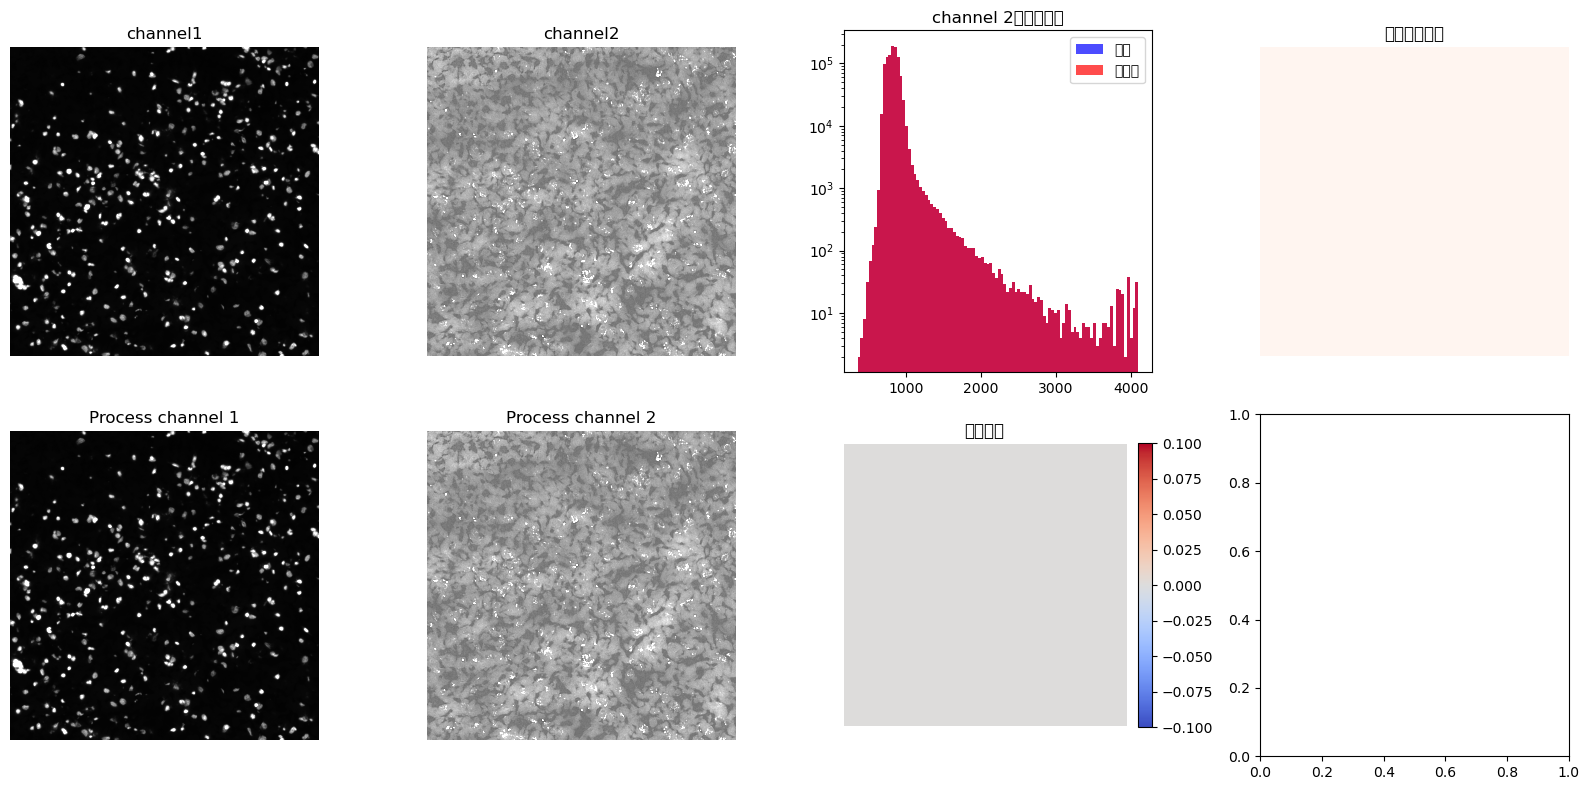

In [35]:
import numpy as np
import tifffile
from skimage import filters, morphology, exposure
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import warnings

def process_and_save_with_metadata(original_path: str, output_path: str, 
                                   channel1_idx: int = 0, channel2_idx: int = 1) -> np.ndarray:
    """
    读取四通道TIFF文件，用通道1对通道2进行去背景处理，并保持原始格式
    
    参数:
        original_path: 原始TIFF文件路径
        output_path: 输出TIFF文件路径
        channel1_idx: 通道1的索引（0-based，默认为0）
        channel2_idx: 通道2的索引（0-based，默认为1）
    
    返回:
        processed_channel2: 处理后的通道2图像
    """
    
    print(f"读取文件: {original_path}")
    
    # 1. 读取原始文件并获取所有元数据
    with tifffile.TiffFile(original_path) as tif:
        # 获取原始图像数据
        original_data = tif.asarray()
        
        # 获取第一页的所有TIFF标签（元数据）
        page0 = tif.pages[0]
        original_tags = {}
        for tag in page0.tags.values():
            original_tags[tag.name] = tag.value
        
        # 打印原始文件信息
        print(f"原始图像信息:")
        print(f"  形状: {original_data.shape}")
        print(f"  数据类型: {original_data.dtype}")
        print(f"  位深度: {page0.bitspersample} bpp")
        print(f"  采样格式: {page0.sampleformat}")
        print(f"  Photometric: {page0.photometric}")
        print(f"  平面配置: {page0.planarconfig}")
        print(f"  压缩: {page0.compression}")
        
        # 检查图像维度
        if len(original_data.shape) == 3:  # (channels, height, width)
            num_channels, height, width = original_data.shape
            print(f"  通道数: {num_channels}")
            print(f"  尺寸: {width}x{height}")
        else:
            raise ValueError(f"不支持的图像维度: {original_data.shape}")
    
    # 2. 提取通道数据
    if num_channels < max(channel1_idx, channel2_idx) + 1:
        raise ValueError(f"图像只有{num_channels}个通道，但请求的通道索引超出范围")
    
    channel1 = original_data[channel1_idx]
    channel2 = original_data[channel2_idx]
    
    # 3. 预处理：保持原始数据类型处理
    def preprocess_channel(channel: np.ndarray) -> np.ndarray:
        """预处理通道，保持原始数据类型"""
        # 转换为浮点数进行计算
        channel_float = channel.astype(np.float32)
        
        # 归一化到0-1范围
        min_val = np.min(channel_float)
        max_val = np.max(channel_float)
        if max_val > min_val:
            channel_norm = (channel_float - min_val) / (max_val - min_val)
        else:
            channel_norm = channel_float
        
        # 高斯滤波去噪
        channel_filtered = filters.gaussian(channel_norm, sigma=1.0)
        return channel_filtered
    
    channel1_proc = preprocess_channel(channel1)
    channel2_proc = preprocess_channel(channel2)
    
    # 4. 检测通道1中的信号区域
    # 使用自适应阈值
    threshold_ch1 = filters.threshold_otsu(channel1_proc)
    mask_ch1 = channel1_proc > threshold_ch1
    
    # 清理掩膜
    mask_ch1 = morphology.remove_small_objects(mask_ch1, min_size=20)
    mask_ch1 = morphology.binary_closing(mask_ch1, morphology.disk(2))
    mask_ch1 = morphology.remove_small_holes(mask_ch1, area_threshold=100)
    
    # 5. 检测通道2中的信号区域
    threshold_ch2 = filters.threshold_otsu(channel2_proc)
    mask_ch2 = channel2_proc > threshold_ch2
    
    # 清理掩膜
    mask_ch2 = morphology.remove_small_objects(mask_ch2, min_size=20)
    mask_ch2 = morphology.binary_closing(mask_ch2, morphology.disk(2))
    
    # 6. 从通道2中移除与通道1重叠的区域
    overlap_mask = np.logical_and(mask_ch1, mask_ch2)
    
    # 从通道2掩膜中移除重叠区域
    mask_ch2_cleaned = np.logical_and(mask_ch2, np.logical_not(overlap_mask))
    
    # 7. 创建处理后的通道2图像
    # 将通道2转换为浮点数以便处理
    channel2_float = channel2.astype(np.float32)
    
    # 估算背景值（使用非信号区域的中值）
    non_signal_mask = np.logical_not(mask_ch2_cleaned)
    if np.any(non_signal_mask):
        background_value = np.median(channel2_float[non_signal_mask])
    else:
        # 如果没有非信号区域，使用最小值
        background_value = np.min(channel2_float)
    
    # 应用处理：重叠区域替换为背景值
    processed_channel2 = channel2_float.copy()
    processed_channel2[overlap_mask] = background_value
    
    # 8. 转换为原始数据类型
    # 保持原始数据范围
    processed_channel2 = np.clip(processed_channel2, 
                                np.iinfo(original_data.dtype).min if np.issubdtype(original_data.dtype, np.integer) else 0,
                                np.iinfo(original_data.dtype).max if np.issubdtype(original_data.dtype, np.integer) else 1.0)
    
    processed_channel2 = processed_channel2.astype(original_data.dtype)
    
    # 9. 创建输出数据
    output_data = original_data.copy()
    output_data[channel2_idx] = processed_channel2
    
    # 10. 保存为与原文件格式完全兼容的TIFF
    print(f"\n保存处理后的文件: {output_path}")
    
    # 构建TIFF标签
    extratags = []
    
    # 添加关键TIFF标签
    if 'ImageDescription' in original_tags:
        description = original_tags['ImageDescription']
        if isinstance(description, str):
            extratags.append((270, 's', 0, description, True))  # 270 = ImageDescription
    
    if 'Software' in original_tags:
        software = original_tags['Software']
        if isinstance(software, str):
            extratags.append((305, 's', 0, software, True))
    
    # 使用TiffWriter保存，保持原始格式
    with tifffile.TiffWriter(output_path, bigtiff=True) as tif_writer:
        tif_writer.save(
            output_data,
            photometric='minisblack' if page0.photometric.value == 1 else page0.photometric,
            planarconfig='separate' if page0.planarconfig.value == 2 else 'contig',
            metadata={'axes': 'CYX'}
        )

    
    # 11. 验证输出文件
    with tifffile.TiffFile(output_path) as tif:
        output_page = tif.pages[0]
        print(f"输出图像信息:")
        print(f"  形状: {tif.asarray().shape}")
        print(f"  数据类型: {tif.asarray().dtype}")
        print(f"  位深度: {output_page.bitspersample} bpp")
        print(f"  尺寸: {output_page.imagewidth}x{output_page.imagelength}")
    
    # 12. 生成处理结果统计
    print(f"\n处理统计:")
    print(f"  通道1信号区域面积: {np.sum(mask_ch1)} 像素")
    print(f"  通道2原始信号区域面积: {np.sum(mask_ch2)} 像素")
    print(f"  重叠区域面积: {np.sum(overlap_mask)} 像素")
    print(f"  处理后通道2信号区域面积: {np.sum(mask_ch2_cleaned)} 像素")
    print(f"  移除比例: {np.sum(overlap_mask)/np.sum(mask_ch2)*100:.2f}%")
    
    return processed_channel2

def visualize_results(original_path: str, processed_path: str, 
                     channel1_idx: int = 0, channel2_idx: int = 1,
                     region: Optional[Tuple[int, int, int, int]] = None):
    """
    可视化处理结果
    """
    # 读取原始和处理后的图像
    with tifffile.TiffFile(original_path) as tif:
        original_data = tif.asarray()
    
    with tifffile.TiffFile(processed_path) as tif:
        processed_data = tif.asarray()
    
    # 如果指定了区域，则截取
    if region:
        x1, y1, x2, y2 = region
        original_data = original_data[:, y1:y2, x1:x2]
        processed_data = processed_data[:, y1:y2, x1:x2]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # 原始图像
    axes[0, 0].imshow(original_data[channel1_idx], cmap='gray', vmax=np.percentile(original_data[channel1_idx], 99))
    axes[0, 0].set_title('channel1')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(original_data[channel2_idx], cmap='gray', vmax=np.percentile(original_data[channel2_idx], 99))
    axes[0, 1].set_title('channel2')
    axes[0, 1].axis('off')
    
    # 处理后的图像
    axes[1, 0].imshow(processed_data[channel1_idx], cmap='gray', vmax=np.percentile(processed_data[channel1_idx], 99))
    axes[1, 0].set_title('Process channel 1')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(processed_data[channel2_idx], cmap='gray', vmax=np.percentile(processed_data[channel2_idx], 99))
    axes[1, 1].set_title('Process channel 2')
    axes[1, 1].axis('off')
    
    # 直方图对比
    axes[0, 2].hist(original_data[channel2_idx].flatten(), bins=100, alpha=0.7, label='before', color='blue')
    axes[0, 2].hist(processed_data[channel2_idx].flatten(), bins=100, alpha=0.7, label='after', color='red')
    axes[0, 2].set_title('channel 2 hit')
    axes[0, 2].legend()
    axes[0, 2].set_yscale('log')
    
    # 差异图像
    diff = processed_data[channel2_idx].astype(np.float32) - original_data[channel2_idx].astype(np.float32)
    im = axes[1, 2].imshow(diff, cmap='coolwarm', vmin=-np.abs(diff).max(), vmax=np.abs(diff).max())
    axes[1, 2].set_title('diff')
    axes[1, 2].axis('off')
    plt.colorbar(im, ax=axes[1, 2], fraction=0.046, pad=0.04)
    
    # 移除区域可视化
    mask = processed_data[channel2_idx] < original_data[channel2_idx]
    axes[0, 3].imshow(mask, cmap='Reds')
    axes[0, 3].set_title('region of removed')
    axes[0, 3].axis('off')
    
    # 缩放显示
    if region is None and original_data.shape[1] > 1000:
        # 自动选择一个中心区域
        h, w = original_data.shape[1], original_data.shape[2]
        region_size = 500
        y_center, x_center = h // 2, w // 2
        zoom_original = original_data[channel2_idx, 
                                     y_center-region_size//2:y_center+region_size//2,
                                     x_center-region_size//2:x_center+region_size//2]
        zoom_processed = processed_data[channel2_idx,
                                        y_center-region_size//2:y_center+region_size//2,
                                        x_center-region_size//2:x_center+region_size//2]
        
        axes[1, 3].imshow(zoom_original, cmap='gray', vmax=np.percentile(zoom_original, 99))
        axes[1, 3].set_title('通道2局部放大')
        axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# 使用示例
if __name__ == "__main__":
    # 文件路径
    input_tiff = "/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/ISH_tiff/HCR-VM11-24-DDRGK1-ctx-10x-1.tif"
    output_tiff = "/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/ISH_tiff/HCR-VM11-24-DDRGK1-ctx-10x-1_rm_back.tif"
    
    try:
        # 执行处理
        print("开始处理原位杂交图像...")
        processed = process_and_save_with_metadata(
            original_path=input_tiff,
            output_path=output_tiff,
            channel1_idx=1,  # 使用通道2对通道3去背景
            channel2_idx=2
        )
        
        print(f"\n处理完成！")
        print(f"原始文件: {input_tiff}")
        print(f"输出文件: {output_tiff}")
        
        # 可视化（可选，可以注释掉以节省时间）
        # 注意：由于图像很大，只显示中心区域
        print("\n生成可视化结果...")
        h, w = processed.shape
        visualize_results(
            original_path=input_tiff,
            processed_path=output_tiff,
            channel1_idx=0,
            channel2_idx=1,
            region=(w//4, h//4, w//4+1000, h//4+1000)  # 显示中心区域的1000x1000像素
        )
        
    except FileNotFoundError as e:
        print(f"错误: 找不到文件 - {e}")
    except Exception as e:
        print(f"处理过程中发生错误: {e}")
        import traceback
        traceback.print_exc()